# CDSMOTE: Class Decomposition and Oversampling for Binary Imbalanced-Data Classification

## Please reference the following paper:
    
Elyan E., Moreno-Garcia C.F., Jayne C., CDSMOTE: class decomposition and synthetic minority class oversampling technique for imbalanced-data classification. Neural Comput Appl. 2020. <a href="https://doi.org/10.1007/s00521-020-05130-z">10.1007/s00521-020-05130-z</a>

### Bibtex Citation
@article{Elyan2020,
author = {Elyan, Eyad and Moreno-Garcia, Carlos Francisco and Jayne, Chrisina},
doi = {10.1007/s00521-020-05130-z},
isbn = {0123456789},
issn = {1433-3058},
journal = {Neural Computing and Applications},
publisher = {Springer London},
title = {{CDSMOTE: class decomposition and synthetic minority class oversampling technique for imbalanced-data classification}},
url = {https://doi.org/10.1007/s00521-020-05130-z},
year = {2020}
}



## Importing the necessary modules

In [1]:
import sys
import clustData
import computeKVs
import numpy as np
import csv
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import svm

## Input parameters

In [2]:
dataset = 'C15' # name of the dataset to use. C1-31 are binary datasets presented in Cleofas-Sanchez et al. 2016
classdecomp = 'Kmeans' # 'FCmeans', 'FCmeansOptimised' and 'DBSCAN' also available 
oversampler = 'SMOTE' #'ADASYN' also available
threshold = 10 # if samples in positive class are apart from average by more than this value, apply oversampling (Sec 3.2 paper)
k_type = 'fixed' # Indicates how to calculate k values for class decomposition
n_clusters = 4 # used in the "fixed" k_type option
number_of_tests = 5 # How many times to repeat the SVM experiment comparing the original and new db

## Load Dataset

In [3]:
## 1. Load dataset
with open('data//'+str(dataset)+'.csv', 'r', newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    data = []
    target = []
    for row in reader:
        data.append(list(map(float,row[0:len(row)-1])))
        target.append(row[-1])
del row, reader, f

majority_class = max(set(target), key=target.count)
minority_class = min(set(target), key=target.count)

## Plotting the original dataset

Dataset: C15
      Class  Number of Samples
0  negative                183
1  positive                 20
Total samples: 203
Imbalance Ratio (IR): 9.15

Showing class distribution bar chart...


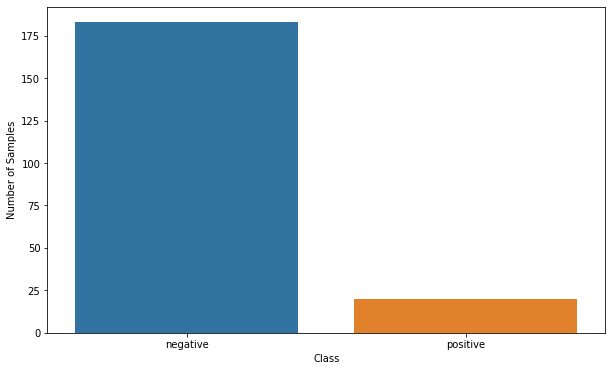

In [4]:
%matplotlib inline
## 3. Plot distribution of original dataset
print('Dataset: '+str(dataset))
histo = [['Class','Number of Samples']]
for i, label1 in enumerate(sorted(list(set(target)))):
    cont = 0
    for j, label2 in enumerate(target):
        if label1 == label2:
            cont+=1
    histo.append([label1,cont])
histo.append(['Total Samples', len(target)])
## Save the histogram as a .csv file   
with open('results/originaldb_classdistribution.csv', 'w', newline='', encoding='utf-8') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for i, hist in enumerate(histo):
        filewriter.writerow(hist)
## Load as a panda
histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
print(histo_panda)
print('Total samples: '+str(len(target)))
## Find IR
majority_samples = histo_panda.loc[histo_panda['Class'] == majority_class].reset_index()
minority_samples = histo_panda.loc[histo_panda['Class'] == minority_class].reset_index()
IR = majority_samples['Number of Samples'][0]/minority_samples['Number of Samples'][0]
print('Imbalance Ratio (IR): '+str(IR))
## Create a histogram using seaborn

sns_plot = sns.barplot(x="Class", y="Number of Samples", data=histo_panda)
## Save the image
sns_plot.figure.set_size_inches(10, 6)
sns_plot.figure.savefig('results/originaldb_barchart'+'.jpg', orientation = 'landscape', dpi = 600)
print('\nShowing class distribution bar chart...')
plt.show()

## Applying class decomposition

In [5]:
## 1.  Calculate k vector (for class decomposition)
if k_type.lower() == 'fixed':
    k = computeKVs.majority(data, target, n_clusters)
elif k_type.lower() == 'ir':
    ## Calculate the IR between the majority and the minority
    n_clusters = math.ceil(IR) 
    k = computeKVs.majority(data, target, n_clusters)
else:
    print('Invalid option for k_type')
    sys.exit()

## 2. Cluster the data
if classdecomp.lower()=='kmeans':
    target_cd = clustData.Kmeans(data, target, k)
elif classdecomp.lower()=='fcmeans':
    target_cd = clustData.FCmeans(data, target, k)
elif classdecomp.lower()=='fcmeansoptimised':
     target_cd = clustData.FCmeansOptimised(data, target, k, max_nclusters = 10)   
elif classdecomp.lower()=='dbscan':        
     target_cd = clustData.DBSCAN(data, target, k, eps=0.5, min_samples=5)
else:
    print('Invalid class decomposition algorithm.')
    sys.exit()


Class decomposition by applying k-means...
Number of clusters for class negative: 4
No clustering performed for class positive.


## Plotting the decomposed datasets

         Class  Number of Samples
0  negative_c0                 68
1  negative_c1                 78
2  negative_c2                 10
3  negative_c3                 27
4  positive_c0                 20
Total samples: 203
Average number of samples per class: 40.6

Showing class distribution bar chart...


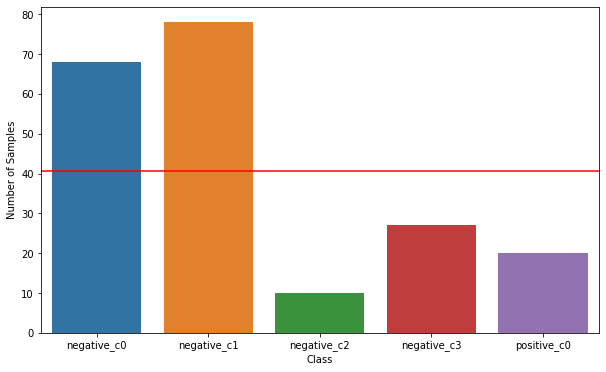

In [6]:
histo = [['Class','Number of Samples']]
for i, label1 in enumerate(sorted(list(set(target_cd)))):
    cont = 0
    for j, label2 in enumerate(target_cd):
        if label1 == label2:
            cont+=1
    histo.append([label1,cont])
histo.append(['Total Samples', len(target_cd)])
## Save the histogram as a .csv file   
with open('results/decomposeddb_classdistribution.csv', 'w', newline='', encoding='utf-8') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for i, hist in enumerate(histo):
        filewriter.writerow(hist)
## Load as a panda
histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
print(histo_panda)
print('Total samples: '+str(len(target_cd)))
## Create a histogram using seaborn
sns_plot = sns.barplot(x="Class", y="Number of Samples", data=histo_panda)
## draw a line depicting the average
indexesUnique = list(set(target_cd))
indexesUnique.sort()
cdclassdist_count = []
cdclassdist_names = []
for cdclass in indexesUnique:
     cdclassdist_count.append(target_cd.count(cdclass))
     cdclassdist_names.append(cdclass)
average = sum(cdclassdist_count)/len(cdclassdist_count)
print('Average number of samples per class:', average)
plt.axhline(average, color='red')
## Save the image
sns_plot.figure.set_size_inches(10, 6)
sns_plot.figure.savefig('results/decomposeddb_barchart'+'.jpg', orientation = 'landscape', dpi = 600)
print('\nShowing class distribution bar chart...')
plt.show()

## Applying oversampling to the minority class w.r.t. the sub-class of the majority class closest to the average (red line). If the minority class is closer to the average than the `threshold`, then this step is skipped.

Oversampling original minority class...
         Class  Number of Samples
0  negative_c0                 68
1  negative_c1                 78
2  negative_c2                 10
3  negative_c3                 27
4  positive_c0                 68
Total samples: 251
New average number of samples per class: 27.2

Showing class distribution bar chart...


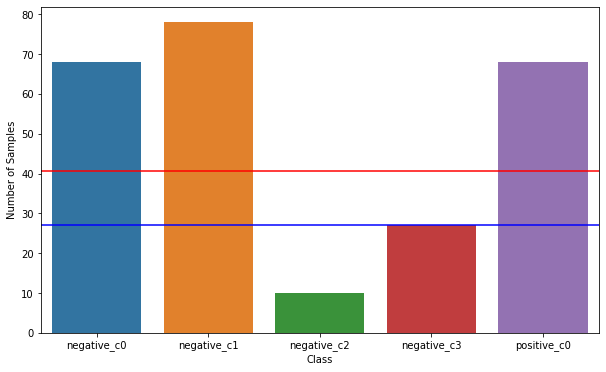

In [7]:
## 1. See if the minority is far from the average (larger than the threshold)
flag = 0
for i,cdclassdist_name in enumerate(cdclassdist_names):
    if minority_class == cdclassdist_name.split('_')[0]:
        if abs(average-cdclassdist_count[i])>threshold and average>cdclassdist_count[i]:
            flag = 1
            newmin = cdclassdist_name
if flag ==1:            
    print('Oversampling original minority class...')
    ## 2. Calculate new majority class (closest to the average and larger than the minority) to use as reference for the oversampling
    c = np.inf
    newmaj = majority_class + '_c0' # gets picked by default if none other accomplishes
    for i,j in enumerate(cdclassdist_count):
        if abs(j-average)<c and j>average:
            c = abs(j-average)
            newmaj = cdclassdist_names[i]
    ## 3. Create the dataset that only contains the new majority and minority classes
    data_majmin = []
    target_majmin = []
    for m, label in enumerate(target_cd):
        if label == newmaj or label == newmin:
            data_majmin.append(data[m])
            target_majmin.append(label)
    if oversampler.lower() == 'smote':
        sm = SMOTE()
        data_over, target_over = sm.fit_resample(data_majmin, target_majmin) 
    elif oversampler.lower() == 'adasyn':
        ada = ADASYN()
        data_over, target_over = ada.fit_resample(data_majmin, target_majmin)
    else:
        print('Invalid oversampling algorithm.')
        sys.exit() 
    ## 4. combine this with the remaning classes
    data_cdsmote = data_over.copy()
    target_cdsmote = target_over.copy()
    for m, label in enumerate(target_cd):
        if label != newmin and label != newmaj:
            data_cdsmote.append(data[m])
            target_cdsmote.append(label)
    
    
    ## 5. Plot distribution after smote
    histo = [['Class','Number of Samples']]
    for i, label1 in enumerate(sorted(list(set(target_cdsmote)))):
        cont = 0
        for j, label2 in enumerate(target_cdsmote):
            if label1 == label2:
                cont+=1
        histo.append([label1,cont])
    histo.append(['Total Samples', len(target_cdsmote)])
    ## Save the histogram as a .csv file   
    with open('results/cdsmotedb_classdistribution.csv', 'w', newline='', encoding='utf-8') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',')
        for i, hist in enumerate(histo):
            filewriter.writerow(hist)
    ## Load as a panda
    histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
    print(histo_panda)
    print('Total samples: '+str(len(target_cdsmote)))
    ## Create a histogram using seaborn
    sns_plot = sns.barplot(x="Class", y="Number of Samples", data=histo_panda)
    ## draw a line depicting the average
    indexesUnique = list(set(target_cdsmote))
    indexesUnique.sort()
    newestclassdist_count = []
    for newestclass in indexesUnique:
         newestclassdist_count.append(target_over.count(newestclass))
    average_new = sum(newestclassdist_count)/len(newestclassdist_count)
    print('New average number of samples per class:', average_new)
    plt.axhline(average, color='red')
    plt.axhline(average_new, color='blue')
    ## Save the image
    sns_plot.figure.set_size_inches(10, 6)
    sns_plot.figure.savefig('results/cdsmotedb_barchart'+'.jpg', orientation = 'landscape', dpi = 600)
    print('\nShowing class distribution bar chart...')
    plt.show()

else:
    data_cdsmote = data.copy()
    target_cdsmote = target_cd.copy()
    print('Original minority class is close to average. No oversampling needed.')


## Save the new dataset in a `.csv` file

In [8]:
## Save the new dataset
with open('results/cdsmotedb.csv', 'w', newline='') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',')
    for j, tar in enumerate(target_cdsmote):
        row = data_cdsmote[j].copy()
        row.append(target_cdsmote[j])
        filewriter.writerow(row)

## Classification

In [9]:
accuracy_o_final = 0
accuracy_c_final = 0

## Split data/target and data_cdsmote/target_cdsmote (stratified and with many splits)
sss = StratifiedShuffleSplit(n_splits=number_of_tests, test_size=0.3, random_state=42)

# Original data
experiments = 0
for train_index, test_index in sss.split(data, target):
    print('\nExperiment '+str(experiments+1)+' Original DB...')
    experiments+=1
    X_train_o, X_test_o,  = np.asarray(data)[train_index], np.asarray(data)[test_index]
    y_train_o, y_test_o = np.asarray(target)[train_index], np.asarray(target)[test_index]
    # Train SVM models
    clf_o = svm.SVC(kernel='linear')
    clf_o.fit(X_train_o, y_train_o)
    y_pred_o = clf_o.predict(X_test_o)
    # Test 
    from sklearn import metrics
    print("Accuracy Original DB:",metrics.accuracy_score(y_test_o, y_pred_o))
    accuracy_o_final = accuracy_o_final + metrics.accuracy_score(y_test_o, y_pred_o)
    
# CDSMOTE data
experiments = 0
for train_index, test_index in sss.split(data_cdsmote, target_cdsmote):
    print('\nExperiment '+str(experiments+1)+' CDSMOTE DB...')
    experiments+=1
    X_train_c, X_test_c,  = np.asarray(data_cdsmote)[train_index], np.asarray(data_cdsmote)[test_index]
    y_train_c, y_test_c = np.asarray(target_cdsmote)[train_index], np.asarray(target_cdsmote)[test_index]
    # Train SVM models
    clf_c = svm.SVC(kernel='linear')
    clf_c.fit(X_train_c, y_train_c)
    y_pred_c = clf_c.predict(X_test_c)
    # Test, making sure accuracy considers sub_classes as good
    accuracy_c=0
    for i,label in enumerate(y_test_c):
        if label.split('_')[0] == y_pred_c[i].split('_')[0]:
           accuracy_c+=1
    print("Accuracy CDSMOTE DB:",accuracy_c/len(y_pred_c))
    accuracy_c_final = accuracy_c_final + accuracy_c/len(y_pred_c)
    
# Final results
print('\nFinal Results:')
print("Average Accuracy Original DB:",accuracy_o_final/experiments)
print("Average Accuracy CDSMOTE DB:",accuracy_c_final/experiments)


Experiment 1 Original DB...
Accuracy Original DB: 0.8852459016393442

Experiment 2 Original DB...
Accuracy Original DB: 0.9508196721311475

Experiment 3 Original DB...
Accuracy Original DB: 0.9836065573770492

Experiment 4 Original DB...
Accuracy Original DB: 0.9508196721311475

Experiment 5 Original DB...
Accuracy Original DB: 0.9508196721311475

Experiment 1 CDSMOTE DB...
Accuracy CDSMOTE DB: 0.9473684210526315

Experiment 2 CDSMOTE DB...
Accuracy CDSMOTE DB: 1.0

Experiment 3 CDSMOTE DB...
Accuracy CDSMOTE DB: 0.9605263157894737

Experiment 4 CDSMOTE DB...
Accuracy CDSMOTE DB: 0.9736842105263158

Experiment 5 CDSMOTE DB...
Accuracy CDSMOTE DB: 0.9736842105263158

Final Results:
Average Accuracy Original DB: 0.944262295081967
Average Accuracy CDSMOTE DB: 0.9710526315789474


Notice that the accuracy to classify this dataset has increased from 94% to 97%!